In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd
from xhistogram.xarray import histogram
import xskillscore as xs
%matplotlib inline
from matplotlib import pyplot as plt
from cmocean import cm
import matplotlib.colors as colors
from matplotlib import gridspec

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5867192.datarmor0/parcels-502027/libparcels_random_5cb53ca1-86f2-4044-8ed1-bcf48a56d904.so


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14) # necessary?
    w = cluster.scale(jobs=1)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [5]:
client

Client Scheduler: tcp://10.148.0.242:33150 Dashboard: http://10.148.0.242:8787/status,Cluster Workers: 14 Cores: 28 Memory: 111.72 GiB


___________
# lat*lon spectra

In [6]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_T365j_dt1j_dij50'
p = pa.parcels_output(root_dir+run_name, parquets=['trajectory'])

In [7]:
E = p.load_diagnostic('spectra_uv_T60_mean0_lon_lat.zarr')
E_L = E.rename({'E':'E_Ls'})
E_L

<xarray.Dataset>
Dimensions:    (frequency: 1440, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * lon_bins   (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
Data variables:
    E_Ls       (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(359, 119, 100), meta=np.ndarray>

In [8]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon.zarr'))
E_Eulerian = (E_Eulerian)
E_E = E_Eulerian.rename({'E_SSUV':'E_Es'})
E_E

<xarray.Dataset>
Dimensions:    (frequency: 1440, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * lon_bins   (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
Data variables:
    E_Es       (frequency, lon_bins, lat_bins) float64 dask.array<chunksize=(180, 45, 30), meta=np.ndarray>

___________
# lat*lon KE

In [9]:
E = '/home/datawork-lops-osi/equinox/mit4320/diags'
L = '/home/datawork-lops-osi/equinox/mit4320/parcels/global_T365j_dt1j_dij50/diagnostics'

In [10]:
E_Eulerian = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_lat_lon_bands_from_2Dbin_spectra.zarr'))
E_Eulerian = E_Eulerian.rename({'E_SSUV':'E_Eulerian'})
E_Eulerian

<xarray.Dataset>
Dimensions:         (frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
Data variables:
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>

In [11]:
E_lagrangian = p.load_diagnostic('spectra_uv_T60_mean0_lat_lon_bands.zarr')
E_lagrangian = E_lagrangian.rename({'E':'E_Lagrangian'})
E_lagrangian = E_lagrangian.E_Lagrangian
E_lagrangian

<xarray.DataArray 'E_Lagrangian' (frequency_band: 14, lon_bins: 359, lat_bins: 119)>
dask.array<open_dataset-46aea3cb5eb387e13604d77af06a32bfE, shape=(14, 359, 119), dtype=float64, chunksize=(1, 359, 119), chunktype=numpy.ndarray>
Coordinates:
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5

### Together

In [12]:
E = xr.merge([E_L,E_E,E_Eulerian,E_lagrangian])
E

<xarray.Dataset>
Dimensions:         (frequency: 1440, frequency_band: 14, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency       (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
  * frequency_band  (frequency_band) object 'total' 'low' ... 'inertial_0dot4'
Data variables:
    E_Ls            (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(359, 119, 100), meta=np.ndarray>
    E_Es            (frequency, lon_bins, lat_bins) float64 dask.array<chunksize=(180, 45, 30), meta=np.ndarray>
    E_Eulerian      (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 45, 30), meta=np.ndarray>
    E_Lagrangian    (frequency_band, lon_bins, lat_bins) float64 dask.array<chunksize=(1, 359, 119), meta=np.ndarray>

___________
# Where

## Eul.

In [13]:
E_E_strong = E.E_Es.where(E.E_Eulerian.sel(frequency_band='total')>1).mean(dim=('lat_bins','lon_bins'))
E_E_strong

<xarray.DataArray 'E_Es' (frequency: 1440)>
dask.array<mean_agg-aggregate, shape=(1440,), dtype=float64, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * frequency       (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
    frequency_band  <U5 'total'

In [14]:
E_E_weak = E.E_Es.where(E.E_Eulerian.sel(frequency_band='total')<0.1).mean(dim=('lat_bins','lon_bins'))
E_E_weak

<xarray.DataArray 'E_Es' (frequency: 1440)>
dask.array<mean_agg-aggregate, shape=(1440,), dtype=float64, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * frequency       (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
    frequency_band  <U5 'total'

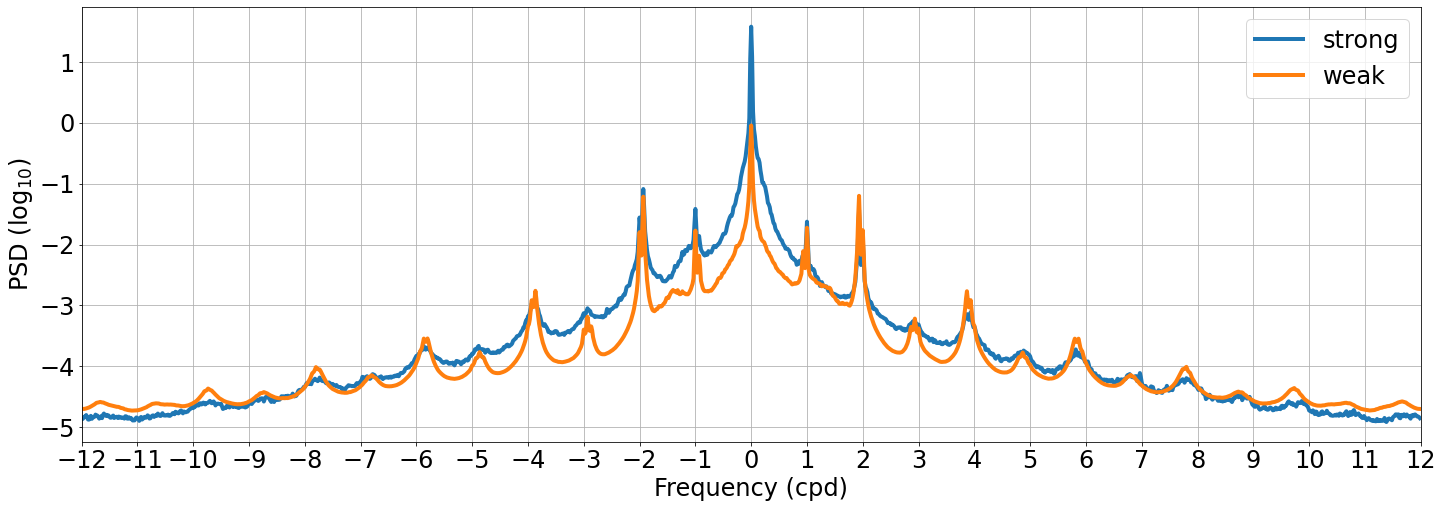

In [15]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['strong', 'weak']
(np.log10(E_E_strong)).plot(ax=ax,label=labels[0],linewidth=4)
(np.log10(E_E_weak)).plot(ax=ax,label=labels[1],linewidth=4)
ax.grid()
ax.legend()
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD (log$_{10}$)',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.set_title('',fontsize=24)
ax.tick_params(labelsize=24)


## Lag.

In [16]:
E_L_strong = E.E_Ls.where(E.E_Lagrangian.sel(frequency_band='total')>1).mean(dim=('lat_bins','lon_bins'))
E_L_strong

<xarray.DataArray 'E_Ls' (frequency: 1440)>
dask.array<mean_agg-aggregate, shape=(1440,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * frequency       (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
    frequency_band  <U5 'total'

In [17]:
E_L_weak = E.E_Ls.where(E.E_Lagrangian.sel(frequency_band='total')<0.1).mean(dim=('lat_bins','lon_bins'))
E_L_weak

<xarray.DataArray 'E_Ls' (frequency: 1440)>
dask.array<mean_agg-aggregate, shape=(1440,), dtype=float64, chunksize=(100,), chunktype=numpy.ndarray>
Coordinates:
  * frequency       (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
    frequency_band  <U5 'total'

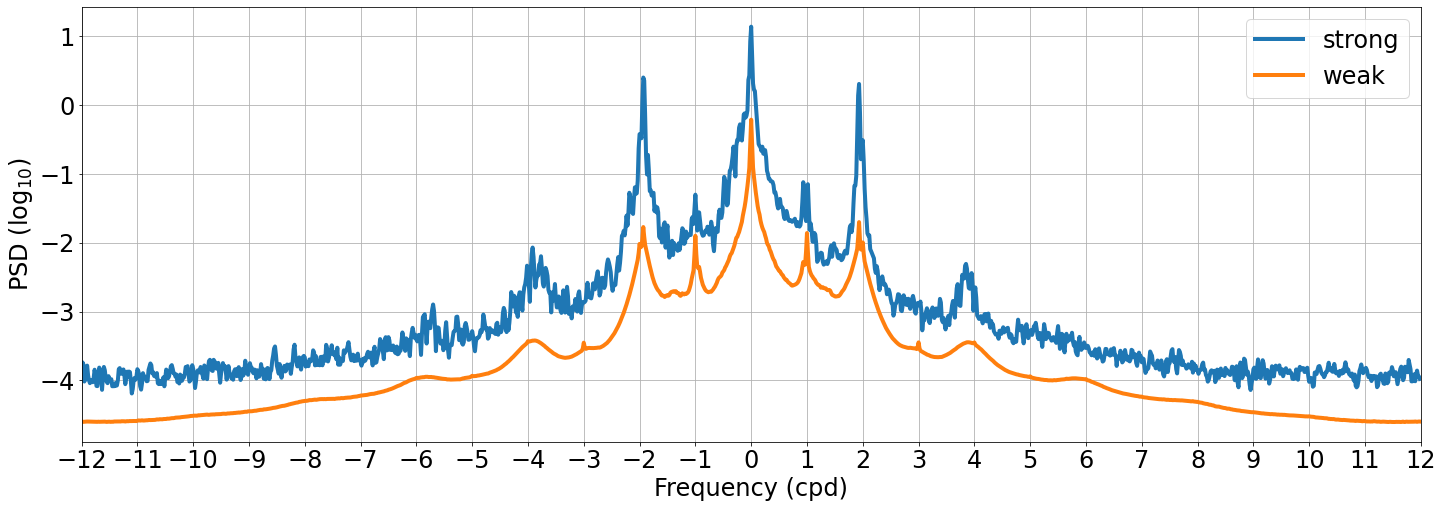

In [18]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['strong', 'weak']
(np.log10((E_L_strong))).plot(ax=ax,label=labels[0],linewidth=4)
(np.log10((E_L_weak))).plot(ax=ax,label=labels[1],linewidth=4)
ax.grid()
ax.legend()
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD (log$_{10}$)',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.set_title('',fontsize=24)
ax.tick_params(labelsize=24)


________
# Groupby

## Eul.

In [19]:
ds = xr.merge([E_E,E_Eulerian.sel(frequency_band='total')])
ds

<xarray.Dataset>
Dimensions:         (frequency: 1440, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency       (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
    frequency_band  <U5 'total'
Data variables:
    E_Es            (frequency, lon_bins, lat_bins) float64 dask.array<chunksize=(180, 45, 30), meta=np.ndarray>
    E_Eulerian      (lon_bins, lat_bins) float64 dask.array<chunksize=(45, 30), meta=np.ndarray>

In [20]:
bins = 10
ds_bin = ds.groupby_bins("E_Eulerian", bins).mean()
ds_bin

<xarray.Dataset>
Dimensions:          (E_Eulerian_bins: 10, frequency: 1440)
Coordinates:
  * E_Eulerian_bins  (E_Eulerian_bins) object (0.00117, 0.176] ... (1.56, 1.733]
  * frequency        (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
    frequency_band   <U5 'total'
Data variables:
    E_Es             (E_Eulerian_bins, frequency) float64 dask.array<chunksize=(1, 180), meta=np.ndarray>
    E_Eulerian       (E_Eulerian_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>

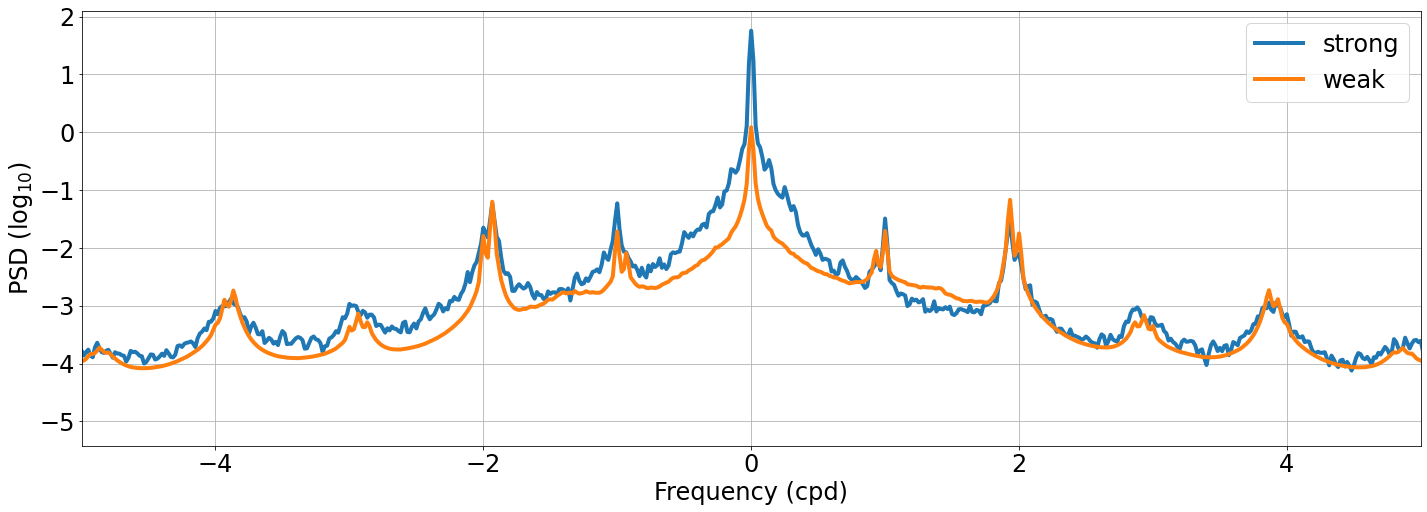

In [21]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['strong', 'weak']
(np.log10((ds_bin.E_Es.isel(E_Eulerian_bins=9)))).plot(ax=ax,label=labels[0],linewidth=4)
(np.log10((ds_bin.E_Es.isel(E_Eulerian_bins=0)))).plot(ax=ax,label=labels[1],linewidth=4)
ax.grid()
ax.legend()
#ax.set_xlim([-12.,12.])
#ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_xlim([-5.,5.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD (log$_{10}$)',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.set_title('',fontsize=24)
ax.tick_params(labelsize=24)

## Lag.

In [22]:
ds = xr.merge([E_L,E_lagrangian.sel(frequency_band='total')])
ds

<xarray.Dataset>
Dimensions:         (frequency: 1440, lat_bins: 119, lon_bins: 359)
Coordinates:
  * frequency       (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
  * lat_bins        (lat_bins) float64 -59.5 -58.5 -57.5 ... 56.5 57.5 58.5
  * lon_bins        (lon_bins) float64 -179.5 -178.5 -177.5 ... 177.5 178.5
    frequency_band  <U5 'total'
Data variables:
    E_Ls            (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(359, 119, 100), meta=np.ndarray>
    E_Lagrangian    (lon_bins, lat_bins) float64 dask.array<chunksize=(359, 119), meta=np.ndarray>

In [23]:
bins = 10
ds_bin = ds.groupby_bins("E_Lagrangian", bins).mean()
ds_bin

<xarray.Dataset>
Dimensions:            (E_Lagrangian_bins: 10, frequency: 1440)
Coordinates:
  * E_Lagrangian_bins  (E_Lagrangian_bins) object (0.00509, 0.159] ... (1.379...
  * frequency          (frequency) float64 -12.0 -11.98 -11.97 ... 11.97 11.98
    frequency_band     <U5 'total'
Data variables:
    E_Ls               (E_Lagrangian_bins, frequency) float64 dask.array<chunksize=(1, 100), meta=np.ndarray>
    E_Lagrangian       (E_Lagrangian_bins) float64 dask.array<chunksize=(1,), meta=np.ndarray>

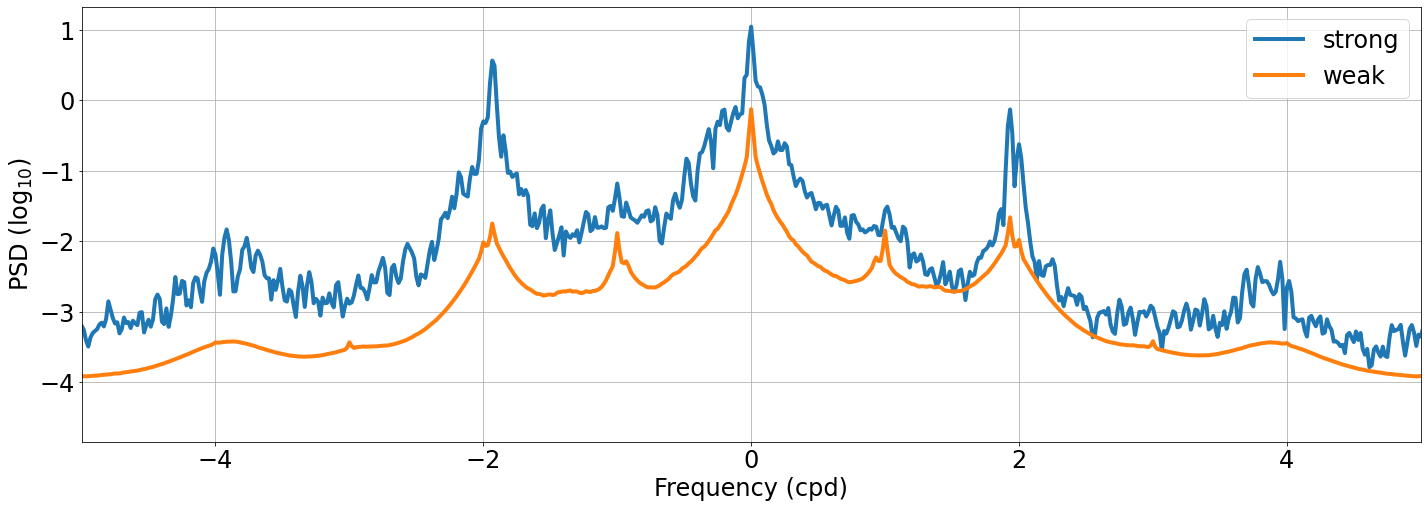

In [24]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['strong', 'weak']
(np.log10((ds_bin.E_Ls.isel(E_Lagrangian_bins=7)))).plot(ax=ax,label=labels[0],linewidth=4)
(np.log10((ds_bin.E_Ls.isel(E_Lagrangian_bins=0)))).plot(ax=ax,label=labels[1],linewidth=4)
ax.grid()
ax.legend()
#ax.set_xlim([-12.,12.])
#ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.set_xlim([-5.,5.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD (log$_{10}$)',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.set_title('',fontsize=24)
ax.tick_params(labelsize=24)

In [27]:
cluster.close()